# Preamble

In [1]:
%pylab inline
# third party
import numpy as np 
np.set_printoptions(suppress=True)

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
torch.set_printoptions(sci_mode=False)


# project 
from code.utils import fetch_mnist

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Get the MNIST data
X_train, Y_train, X_test, Y_test = fetch_mnist()

# PyTorch implementation of a simple NN

loss 0.21 accuracy 0.93: 100%|██████████| 1000/1000 [00:04<00:00, 226.76it/s]


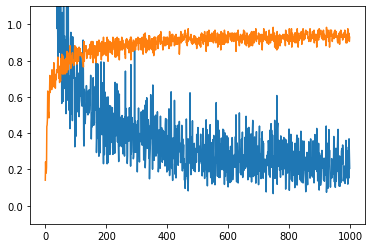

In [3]:
class ArtNet(torch.nn.Module):
    def __init__(self):
        super(ArtNet, self).__init__()
        self.l1 = nn.Linear(784, 128, bias=False)
        self.l2 = nn.Linear(128, 10, bias=False)
        self.sm = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        x = self.sm(x)
        return x
    
model = ArtNet()
loss_fn = nn.NLLLoss(reduction="none")
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
batch_size = 128
losses, accuracies = [], []

iterator = trange(1000)
for i in iterator:
    smpl = np.random.randint(0, X_train.shape[0], size=batch_size)
    X = torch.tensor(X_train[smpl].reshape((-1, 28*28))).float()
    Y = torch.tensor(Y_train[smpl]).long()
    optim.zero_grad()
    
    out = model(X)
    cat = out.argmax(dim=1)
    
    accuracy = (cat == Y).float().mean()
      
    loss = loss_fn(out, Y).mean()
    loss.backward()
    
    optim.step()
    
    losses.append(loss.item())
    accuracies.append(accuracy.item())
    iterator.set_description(f"loss {loss:.2f} accuracy {accuracy:.2f}")

plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

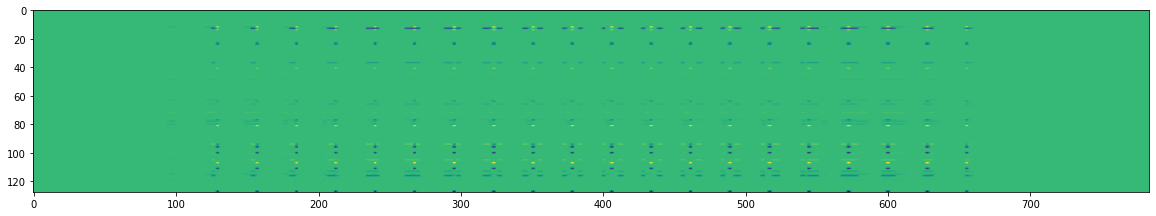

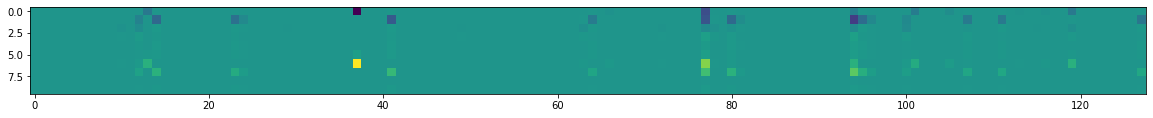

In [15]:
# Show gradients 
samp = [0,1,2,3]
model.zero_grad()
out = model(torch.tensor(X_test[samp].reshape((-1, 28*28))).float())
out.retain_grad()
loss = loss_fn(out, torch.tensor(Y_test[samp]).long()).mean()
loss.backward()
figure(figsize=(20, 20))
imshow(model.l1.weight.grad)
figure(figsize=(20, 20))
imshow(model.l2.weight.grad)

In [16]:
# Implement a simple forward pass and check the test accuracy
W1 = model.l1.weight.detach().numpy().T
W2 = model.l2.weight.detach().numpy().T

def numpy_eval():
    def forward(x):
        x = x.dot(W1)
        x = np.maximum(x, 0)
        return x.dot(W2)
    
    Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
    Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
    return (Y_test == Y_test_preds).mean()

numpy_eval()

0.9307

# NumPy implementation

Notes:
- [Vector & Matrix calculus and other maths](http://cs231n.stanford.edu/slides/2018/cs231n_2018_ds02.pdf)


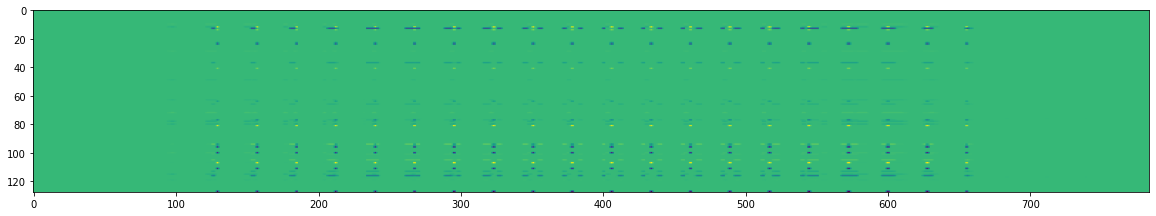

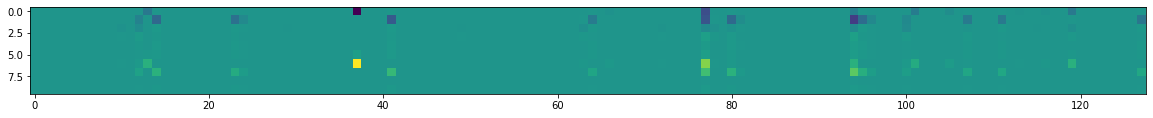

In [18]:
def logsumexp(x):
    # LogSoftMax docs: https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html
    # Source: http://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    #return np.log(np.exp(x).sum(axis=1))
    c = x.max(axis=1)
    return c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))

def initialize_layer(m, h):
#     return np.random.randn(m,h) * np.sqrt(2/m)
    ret = np.random.uniform(-1., 1., size=(m,h))/np.sqrt(m*h)
    return ret.astype(np.float32)

def forward_grads(x,y, W1, W2):
    # One hot encoding
    out = np.zeros((len(y), 10))
    out[range(len(y)), y] = 1    
    
    x_l1 = x.dot(W1)
    x_relu = np.maximum(x_l1, 0)
    x_l2 = x_relu.dot(W2)
    x_lsm = x_l2 - logsumexp(x_l2).reshape((-1, 1))
    x_loss = (-out * x_lsm).mean(axis=1)
    
#   Don't really get this. This relates the gradient of the output (what even is that?) to the size 
#   of the batch. I presume this is due to the fact that you want to have gradients in the end adjusted
#   to the fact that this is Mini-Batch Gradient Descent and you don't want to divide the gradients at each
#   layer so you just do it here.
#     d_out = -out / len(y)
    d_out = -out / len(y)

    # dL/dy_hat
    d_lsm = d_out - np.exp(x_lsm)*d_out.sum(axis=1).reshape((-1,1))
    
    # dL/dW2
    d_W2  = x_relu.T.dot(d_lsm)
   
    # dL/dh1
    d_relu = d_lsm.dot(W2.T)
    
    # dh1/dz1
    d_z1 = (x_relu > 0).astype(np.float32) * d_relu
    
    # dz1/dW1
    d_W1 = x.T.dot(d_z1)

    return x_loss, x_l2, d_W1, d_W2

samp = [0,1,2,3]
x_loss, x_l2, d_l1, d_l2 = forward_grads(X_test[samp].reshape((-1, 28*28),), Y_test[samp], W1, W2)

figure(figsize=(20, 20))
imshow(d_l1.T)
figure(figsize=(20, 20))
imshow(d_l2.T)


loss 0.01 accuracy 0.98: 100%|██████████| 1000/1000 [00:05<00:00, 190.92it/s]


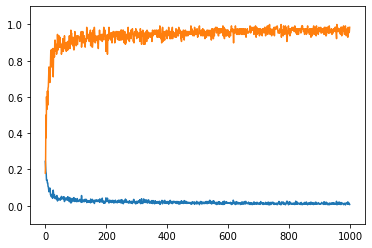

In [19]:
# Train
np.random.seed(1337)
W1 = initialize_layer(784, 128)
W2 = initialize_layer(128, 10)

lr = 0.001
BS = 128
losses, accuracies = [], []
for i in (t := trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = X_train[samp].reshape((-1, 28*28))
    Y = Y_train[samp]
    x_loss, x_l2, d_l1, d_l2 = forward_grads(X, Y, W1, W2)
  
    cat = np.argmax(x_l2, axis=1)
    accuracy = (cat == Y).mean()
  
    # SGD
    W1 = W1 - lr*d_l1
    W2 = W2 - lr*d_l2
  
    loss = x_loss.mean()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
  
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)
